In [24]:
from collections import defaultdict
import math
import numpy as np
import pandas as pd
from typing import List

#@title Debugging
# See https://zohaib.me/debugging-in-google-collab-notebook/ for tips,
# as well as docs for pdb and ipdb.
DEBUG = False #@param {type:"boolean"}
GDRIVE_BASE = "/content/drive" #@param
DATAFRAME_PATH = "/MyDrive/amazon_rainforest_files/monthly_large.csv" #@param

def get_dataframe_path_from_params() -> str:
  root = GDRIVE_BASE if GDRIVE_BASE else ""
  return f"{root}{DATAFRAME_PATH}"

In [ ]:
# Access data stored on Google Drive
if GDRIVE_BASE:
    from google.colab import drive
    drive.mount(GDRIVE_BASE)

if DEBUG:
    %pip install -Uqq ipdb
    import ipdb
    %pdb on

In [37]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, regularizers
from matplotlib import pyplot as plt

def kl_divergence_loss(real, predicted):
    real_value = real[0]
    real_variance = real[1] + 0.00000001
    predicted_value = predicted[0]
    predicted_variance = predicted[1] + 0.00000001

    kl_loss = -0.5 + tf.math.log(predicted_variance/real_variance) + \
     (tf.square(real_variance) + tf.square(real_value - predicted_value))/ \
     2*tf.square(predicted_variance)
    return tf.math.reduce_mean(kl_loss)

def train_nn(
        X: pd.DataFrame,
        Y: pd.DataFrame,
        hidden_layers: List[int],
        epochs: int,
        batch_size: int):
    # Layers share between mean and variance regressors.
    shared_layers = []
    for num_nodes in hidden_layers:
        shared_layers.append(layers.Dense(
            num_nodes,
            activation='relu'))

    #Initialize input layers and connect them to shared layers.
    num_inputs = X.shape[1]
    inputs = keras.Input(shape=(num_inputs,))
    x = inputs
    for shared_layer in shared_layers:
        x = shared_layer(x)

    # Output is variance and mean, and connect to shared nodes.
    mean_output_layer = layers.Dense(1, activation='linear', name='mean_output')
    mean_output_node = mean_output_layer(x)
    variance_output_layer = layers.Dense(1, activation='relu', name='variance_output')
    variance_output_node = variance_output_layer(x)
    outputs = [mean_output_node, variance_output_node]

    model = keras.Model(inputs=inputs, outputs=outputs)

    optimizer = keras.optimizers.Adam(learning_rate=0.0001)
    model.compile(optimizer=optimizer, loss={'mean_output': 'mse', 'variance_output': kl_divergence_loss})
    history = model.fit(X, Y, epochs=epochs, batch_size=batch_size)
    return history, model

def render_plot_loss(history):
  plt.plot(history.history['mean_output_loss'])
  plt.plot(history.history['variance_output_loss'])
  plt.title('model loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['mean', 'variance'], loc='upper left')
  plt.show()

Data preparation:

In [40]:
from sklearn.model_selection import train_test_split

df = pd.read_csv(get_dataframe_path_from_params())

group_on = ['sample_site_lon', 'sample_site_lat', 'month_of_year']
grouped = df.groupby(group_on)

# ASSUMPTION: Taking the mean and variance of a sample site doesn't lower quality of the data.
# We need to do this to take advantage of KL-divergence loss.
means = grouped.mean()
O18_var = grouped.var()['cellulose_oxygen_ratio']

# Merging results in some unreadable column names. Rename the oxygen columns.
merged = pd.merge(means, O18_var, on=group_on, how='inner')
merged = merged.rename(columns={
    'cellulose_oxygen_ratio_x': 'O18_mean',
    'cellulose_oxygen_ratio_y' : 'O18_var'})

train, test = train_test_split(merged, test_size=0.25, random_state=25)

# Target data: Mean and variance
Y_train = train[["O18_mean", "O18_var"]]
Y_test = test[["O18_mean", "O18_var"]]

def format_output(Y):
  y1 = Y.pop("O18_mean")
  y1 = np.array(y1)
  y2 = Y.pop("O18_var")
  y2 = np.array(y2)
  return y1, y2

Y_train = format_output(Y_train)
Y_test = format_output(Y_test)

# Features: Everything besides mean and variance
X_train = train.drop(["O18_mean", "O18_var"], axis=1)
X_test = test.drop(["O18_mean", "O18_var"], axis=1)
X_train.drop(X_train.columns[X_train.columns.str.contains('unnamed',case = False)],axis = 1, inplace = True)
X_test.drop(X_test.columns[X_test.columns.str.contains('unnamed',case = False)],axis = 1, inplace = True)

Variance KL-loss: 0.9

Mean MSE loss: 26.37

"General loss": 27.03

In [ ]:
# Train
history, model = train_nn(X_train, Y_train, hidden_layers=[12, 26], epochs=500, batch_size=100)

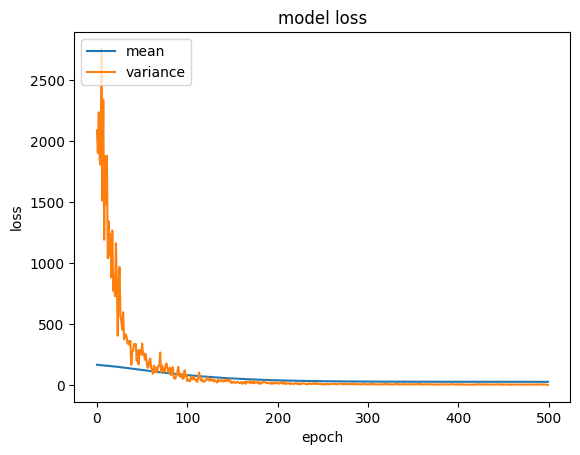

In [42]:
render_plot_loss(history)

In [43]:
model.evaluate(x=X_test, y=Y_test)

2/2 [==============================] - 0s 7ms/step - loss: 25.2460 - mean_output_loss: 22.1462 - variance_output_loss: 3.0999


[25.246023178100586, 22.146162033081055, 3.099860191345215]